In [1]:
from src.packages.loaders import DataLoader
from src.packages.loaders import ModelLoader
from common import path_to_data, path_to_models
import numpy as np

all_patterns_and_its_intents_train = DataLoader.load_pandas_dataframe(
    path_to_data / 'all_patterns_and_its_intents_train.csv')
all_patterns_and_its_intents_test = DataLoader.load_pandas_dataframe(
    path_to_data / 'all_patterns_and_its_intents_test.csv')
all_patterns_and_its_intents_train

pattern            intent
0      Вот так и живём, что все по понятиям, а не по ...     offline_crime
1      Я бы с удовольствием пообщался с хардингушем, ...     offline_crime
2      У нас его вообще запретить надо. Судя по сводк...     offline_crime
3            Много полковников у них миллиардами воруют?     offline_crime
4      В Чебоксарах гайцы такие. Как увидят другой ре...     offline_crime
...                                                  ...               ...
99681             зарплаты в швейцарии тоже не маленькие  social_injustice
99682  По NUMBER-NUMBER часов в день. Начал серьезно ...  social_injustice
99683  % налогов слишком мало, нужно больше, тогда то...  social_injustice
99684  Можно. Но только такие постройки не соответств...  social_injustice
99685  везде так просто жесть! но-в NUMBER очередь на...  social_injustice

[99686 rows x 2 columns]

In [2]:
from src.packages.pipe.preprocess_sentence import *
from sklearn.pipeline import make_pipeline
import joblib

preprocess_sentence = make_pipeline(
    RemoveGarbage(),
    CorrectOrthography(),
    RemovePunctuation(),
    Tokenize(),
    ToBaseForm(),
    RemoveStopWords(),
)

preprocess_sentence

Pipeline(steps=[('removegarbage', RemoveGarbage()),
                ('correctorthography', CorrectOrthography(lang=['en', 'ru'])),
                ('removepunctuation', RemovePunctuation()),
                ('tokenize', Tokenize()), ('tobaseform', ToBaseForm()),
                ('removestopwords', RemoveStopWords())])

In [3]:
joblib.dump(preprocess_sentence, path_to_models / 'pipelines' / 'preprocess_sentence.joblib')
ModelLoader.load(path_to_models / 'pipelines' / 'preprocess_sentence.joblib').transform(
    "привет как дела")

['привет', 'дело']

In [4]:
from tqdm import tqdm


def preprocess_patterns(all_patterns_and_its_intents, pipeline=preprocess_sentence):
    all_patterns_preprocessed_and_its_intents = all_patterns_and_its_intents.copy()
    with tqdm(total=len(all_patterns_preprocessed_and_its_intents)) as pbar:
        for i, row in all_patterns_preprocessed_and_its_intents.iterrows():
            all_patterns_preprocessed_and_its_intents.at[i, "pattern"] = pipeline.transform(row["pattern"])
            pbar.update(1)

    return all_patterns_preprocessed_and_its_intents


preprocess_patterns(all_patterns_and_its_intents_train[:10])

100%|██████████| 10/10 [00:03<00:00,  2.69it/s]


pattern         intent
0  [жить, всё, понятие, закон, просто, преступлен...  offline_crime
1  [удовольствие, пообщаться, хардингуш, тип, чёт...  offline_crime
2  [вообще, запретить, судить, сводка, дтп, это, ...  offline_crime
3                    [полковник, миллиард, воровать]  offline_crime
4  [чебоксары, гайец, увидеть, регион, палка, сра...  offline_crime
5  [спокойный, куст, человек, прыгать, медленно, ...  offline_crime
6  [бардак, мажор, делать, хотеть, вообще, всё, п...  offline_crime
7  [почему, просто, посадить, пара, день, вода, х...  offline_crime
8  [это, взяткадлить, взять, взятка, больший, раз...  offline_crime
9  [сказать, секрет, number, год, молдавия, закон...  offline_crime

## Предскажем сколько времени понадобится для всех фраз

100%|██████████| 10/10 [04:21<00:00, 26.14s/it]


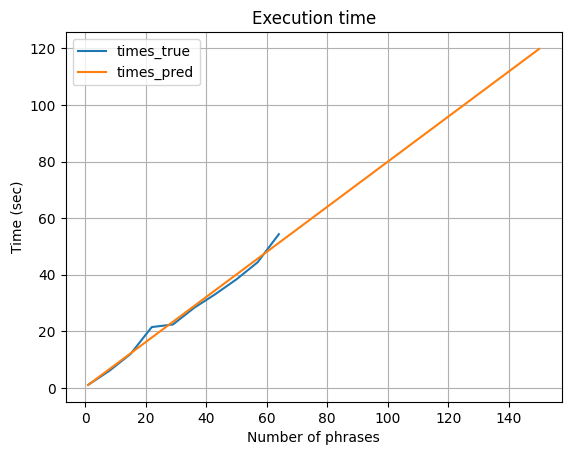

In [40]:
from sklearn.linear_model import LinearRegression
import time
import matplotlib.pyplot as plt


def learn_time_func(x_true, x_to_pred, func, all_patterns_and_its_intents, is_plot=True):
    times = []
    for x in tqdm(x_true):
        start_time = time.perf_counter()
        func(all_patterns_and_its_intents[:x])
        end_time = time.perf_counter()
        times.append(end_time - start_time)

    X = np.array(x_true).reshape((-1, 1))
    time_func = LinearRegression()
    time_func.fit(X, times)
    X_to_pred = np.array(x_to_pred).reshape((-1, 1))
    times_pred = time_func.predict(X_to_pred)

    if is_plot:
        plt.xlabel('Number of phrases')
        plt.ylabel('Time (sec)')
        plt.title('Execution time')
        plt.plot(X, times, label='times_true')
        plt.plot(X_to_pred, times_pred, label='times_pred')
        plt.legend()
        plt.grid()
        plt.show()
    return time_func


x_true = range(1, 71, 7)
x_pred = range(1, 151)
time_func = learn_time_func(x_true, x_pred, preprocess_patterns, all_patterns_and_its_intents_train.sample(frac=1))

In [38]:
time_func.predict(np.array(all_patterns_and_its_intents_train.shape[0]).reshape((-1, 1))) / 60 / 60

array([21.2635341])

In [39]:
time_func.predict(np.array(all_patterns_and_its_intents_test.shape[0]).reshape((-1, 1))) / 60 / 60

array([5.33233673])

## Попробуем оптимизировать

In [50]:
time_func.predict(np.array(100).reshape((-1, 1)))

array([79.97118147])

In [4]:
sep_token = ". "
total_characters = len(sep_token.join(all_patterns_and_its_intents_train["pattern"]))
print("Подавать строки в длиной более 40к нежелательно в CorrectOrthography")
print("Средняя длина строки", total_characters // len(all_patterns_and_its_intents_train), "символов")
print("Можно подавать в один батч где-нибудь по 300 фраз, 116*300=", 116 * 300)
print(
    f"Для этого all_patterns_and_its_intents_train нужно разделить на {len(all_patterns_and_its_intents_train) // 300} батча")
print(f"А all_patterns_and_its_intents_test нужно разделить на {len(all_patterns_and_its_intents_test) // 300} батчей")

Подавать строки в длиной более 40к нежелательно в CorrectOrthography
Средняя длина строки 122 символов
Можно подавать в один батч где-нибудь по 300 фраз, 116*300= 34800
Для этого all_patterns_and_its_intents_train нужно разделить на 332 батча
А all_patterns_and_its_intents_test нужно разделить на 83 батчей


In [5]:
import pandas as pd


def correct_orthography_batch(patterns, n_batches=1, sep_token=" "):
    """
    Функция собирает все переданные фразы в n_batches батчей и подаёт их последовательно шагу пайплайна CorrectOrthography.
    На данный момент этот шаг обращается к оперделённому api Yandex, которое быстрее работает на большом тексте.
    Также из-за этого нужно аккуратно выбирать sep_token, так как api не предусматривает игнорирование определённых слов.
    Лучшим sep_token будет являться неразрывный пробел при условии, что во входном тексте таких пробелов не будет.
    :param patterns: список всех фраз
    :param n_batches: количество батчей
    :param sep_token: токен, по которому будут соединяться все фразы в рамках одного батча
    :return: список исправленных фраз
    """
    patterns_batches = np.array_split(patterns.values, n_batches)
    correct_orthography = CorrectOrthography(lang=['ru'], ignore_uppercase=True)
    sep_token_for_text = "." + sep_token
    all_patterns_separated_by_a_token_list = []
    for patterns_batch in tqdm(patterns_batches):
        patterns_separated_by_a_token = sep_token_for_text.join(patterns_batch.tolist())
        patterns_separated_by_a_token = correct_orthography.transform(patterns_separated_by_a_token)
        all_patterns_separated_by_a_token_list.append(patterns_separated_by_a_token)

    all_patterns_separated_by_a_token_list = sep_token.join(all_patterns_separated_by_a_token_list)
    try:
        patterns_preprocessed = pd.DataFrame({'pattern': all_patterns_separated_by_a_token_list.split(sep_token)},
                                         index=patterns.index)
    except ValueError as ex:
        patterns_preprocessed = pd.DataFrame({'pattern': all_patterns_separated_by_a_token_list.split(sep_token)})
    return patterns_preprocessed


correct_orthography_batch(all_patterns_and_its_intents_train["pattern"].sample(frac=1).head(300).apply(lambda x: RemoveGarbage.transform(x)), 1)

100%|██████████| 1/1 [00:01<00:00,  1.51s/it]


pattern
67010  Сколько в детской инфекционной больнице лежат ...
17961  Всю жизнь с самого детства горит очаг от того ...
73461  Нормально. У меня на говнофирме работало два м...
27947     потому что тряпки половые добавлять перестали.
79999  Иудеям запрещается создавать изображения Б-гов...
...                                                  ...
60707  И такой пытался, но то ли у меня она какая-то ...
32305            По пять тысяч за год, очевидно же , ну.
42160  У миллионов людей заведомо мучительная жизнь. ...
37172  Чтобы так сказать подчеркнуть, что вы тут никт...
43166  По такой логике покупай жигули и ебашь по трот...

[300 rows x 1 columns]

In [17]:
text = "Приветствую всех, которые прочтут этот текст. Я надеюсь, что вы понимаете, что я написал в этом сообщении. Это важно, потому что я пытаюсь передать вам важную информацию о том, как проверять вашу письменность. Одна из главных проблем, которую я вижу в людях, это недостаточная проверка текста на ошибки. Часто люди просто не замечают опечатки, даже если они являются очевидными. Это может привести к тому, что ваша коммуникация будет менее эффективной и некоторые люди могут просто игнорировать то, что вы говорите. Поэтому я настоятельно рекомендую проверять свой текст перед отправкой, чтобы убедиться, что он не содержит ошибок."
text = text + sep_token
text = text + "Если вы не уверены в своих навыках проверки письменности, не беспокойтесь, есть много онлайн-инструментов, которые могут помочь вам с этим. Вы можете использовать грамматические проверки, проверки орфографии и другие инструменты, чтобы убедиться, что ваш текст не содержит ошибок. Также стоит помнить, что правильное использование знаков препинания очень важно для ясности и понимания вашего текста. Если вы не уверены, как использовать знаки препинания, есть много онлайн-ресурсов, которые могут помочь вам изучить эти правила. Важно также помнить, что ваша коммуникация не только должна быть грамматически правильной, но и четкой и легко читаемой. Используйте простые и понятные слова, структурируйте свой текст в параграфы, чтобы он был легче воспринимаемым. Наконец, не забывайте, что ваша коммуникация должна быть уважительной и дружелюбной, чтобы вы могли добиться лучших результатов в своих деловых и личных отношениях."
text = text + sep_token
text = text + "Кроме того, если вы пишете на другом языке, будьте внимательны к тонкостям перевода. Некоторые слова и выражения могут иметь различные значения в зависимости от контекста и культурных нюансов. Поэтому, если вы не уверены в правильности перевода, лучше всего проконсультироваться с носителем языка или профессиональным переводчиком."
text = text + sep_token
text = text + "В конечном итоге, правильное написание и оформление текста - это не только проявление грамотности, но и уважение к читателю и готовность предоставить четкую информацию. И хотя опечатки и ошибки могут случаться у каждого, следует всегда стремиться к тому, чтобы сделать свой текст максимально понятным и убедительным. Будьте внимательны и тщательны в своих письменных коммуникациях, и вы сможете добиться большего успеха в своей личной и профессиональной жизни."
text = text + sep_token
text = text + "Привитсвую воссех, которые прочтут этот текс. Я надеюсь, что вы понимаети, что я нуписал в этом соовщении. Это важно, поутому что я пытаюсь пердать вам важную инфрмацию о том, как проверять вашу письменность. Одна из главнх проблем, которую я вижу в людях, это недостаточная проверка текста на ошибки. Часто люди просто не замечают оепчатки, даже если они являютса очевидными. Это может привети к тому, что ваша коммуникация будет менее эффективной и некоторые люди могут просто игнорировать то, что вы говорите. Поэтому я настоятльно рекомндую првоерять свой текст перед отправкои, чтобы убедиться, что он не содержит ошбик."
text = text + sep_token
text = text + "Если вы не уверены в своих навыках проверки письменности, не беспокойтесь, есть много онлайн-инструмнтов, которые могут помочь вам с этим. Вы можете исполюзовать граматические проверки, проверки орфографии и другие инструменты, чтобы убедитсья, что ваш текст не содержит ошипок. Также стоит помнить, что правильное исрользование знаков препинания очень важно для ясности и понимания вашего текста. Если вы не уверены, как использовать знаки препинания, есть много онлайн-ресурсов, которые могут помочь вам изучить эти правила. Важно также помнить, что ваша коммуникация не только должна быть грамотно правильной, но и четкой и легко читаемой."
text = text + sep_token
text = text + "Используйте простые и понятные слова, структурируйте свой текст в параграфы, чтобы он был легче воспринимаемым. Наконец, не забывайте, что ваша коммуникация должна бить уважительной и дружелюбной, чтобы вы могли добитьсся лучших результантов в своих деловых и личных отношениях."
text

'Приветствую всех, которые прочтут этот текст. Я надеюсь, что вы понимаете, что я написал в этом сообщении. Это важно, потому что я пытаюсь передать вам важную информацию о том, как проверять вашу письменность. Одна из главных проблем, которую я вижу в людях, это недостаточная проверка текста на ошибки. Часто люди просто не замечают опечатки, даже если они являются очевидными. Это может привести к тому, что ваша коммуникация будет менее эффективной и некоторые люди могут просто игнорировать то, что вы говорите. Поэтому я настоятельно рекомендую проверять свой текст перед отправкой, чтобы убедиться, что он не содержит ошибок.. TECH_SEPARATOR Если вы не уверены в своих навыках проверки письменности, не беспокойтесь, есть много онлайн-инструментов, которые могут помочь вам с этим. Вы можете использовать грамматические проверки, проверки орфографии и другие инструменты, чтобы убедиться, что ваш текст не содержит ошибок. Также стоит помнить, что правильное использование знаков препинания оч

In [19]:
all_phrases_separated_by_a_token = CorrectOrthography().transform(text)
text_df = pd.DataFrame({'pattern': all_phrases_separated_by_a_token.split(sep_token)})
text_df

pattern
0  Приветствую всех, которые прочтут этот текстт....
1  Если вы не уверены в своих навыках проверки пи...
2  Кроме того, если вы пишете на другом языке, бу...
3  В конечном итоге, правильное написание и оформ...
4  Приветствую всех, которые прочтут этот текст. ...
5  Если вы не уверены в своих навыках проверки пи...
6  Используйте простые и понятные слова, структур...

In [20]:
text_df["pattern"][4]

'Приветствую всех, которые прочтут этот текст. Я надеюсь, что вы понимаете, что я написал в этом сообщении. Это важно, потому что я пытаюсь передать вам важную информацию о том, как проверять вашу письменность. Одна из главных проблем, которую я вижу в людях, это недостаточная проверка текстта на ошибки. Часто люди просто не замечают отпечатки, даже если они являются очевидными. Это может привести к тому, что ваша коммуникация будет менее эффективной и некоторые люди могут просто игнорировать то, что вы говорите. Поэтому я настоятельно рекомендую проверять свой текстт перед отправкой, чтобы убедиться, что он не содержит ошибок.'

## Теперь можно обработать весь пул фраз

In [6]:
all_patterns_and_its_intents_train = preprocess_patterns(all_patterns_and_its_intents_train, RemoveGarbage())

100%|██████████| 99686/99686 [02:19<00:00, 716.45it/s] 


In [7]:
all_patterns_and_its_intents_test = preprocess_patterns(all_patterns_and_its_intents_test, RemoveGarbage())

100%|██████████| 24997/24997 [00:05<00:00, 4199.78it/s]


In [16]:
all_patterns_corrected_orthography_and_its_intents_train = all_patterns_and_its_intents_train.copy()
all_patterns_corrected_orthography_and_its_intents_train["pattern"] = correct_orthography_batch(all_patterns_and_its_intents_train["pattern"], n_batches=400)
all_patterns_corrected_orthography_and_its_intents_train

100%|██████████| 400/400 [09:16<00:00,  1.39s/it]


pattern            intent
0      Вот так и живём, что все по понятиям, а не по ...     offline_crime
1      Я бы с удовольствием пообщался с хардингушем, ...     offline_crime
2      У нас его вообще запретить надо. Судя по сводк...     offline_crime
3           Много полковников у них миллиардами воруют?.     offline_crime
4      В Чебоксарах гайцы такие. Как увидят другой ре...     offline_crime
...                                                  ...               ...
99681           зарплаты в швейцарии чтоже не маленькие.  social_injustice
99682  По NUMBER-NUMBER часов в день. Начал серьезно ...  social_injustice
99683   налогов слишком мало, нужно больше, чтогда чт...  social_injustice
99684  Можно. Но чтолько такие постройки не соответст...  social_injustice
99685  везде так просчто жесть! но-в NUMBER очередь н...  social_injustice

[99686 rows x 2 columns]

In [17]:
# удаляем служебные точки в конце предложений, которые были добавлены функцией correct_orthography_batch
all_patterns_corrected_orthography_and_its_intents_train["pattern"] = all_patterns_corrected_orthography_and_its_intents_train["pattern"].apply(lambda x: x[:-1])
all_patterns_corrected_orthography_and_its_intents_train

pattern            intent
0      Вот так и живём, что все по понятиям, а не по ...     offline_crime
1      Я бы с удовольствием пообщался с хардингушем, ...     offline_crime
2      У нас его вообще запретить надо. Судя по сводк...     offline_crime
3            Много полковников у них миллиардами воруют?     offline_crime
4      В Чебоксарах гайцы такие. Как увидят другой ре...     offline_crime
...                                                  ...               ...
99681            зарплаты в швейцарии чтоже не маленькие  social_injustice
99682  По NUMBER-NUMBER часов в день. Начал серьезно ...  social_injustice
99683   налогов слишком мало, нужно больше, чтогда чт...  social_injustice
99684  Можно. Но чтолько такие постройки не соответст...  social_injustice
99685  везде так просчто жесть! но-в NUMBER очередь н...  social_injustice

[99686 rows x 2 columns]

In [18]:
all_patterns_corrected_orthography_and_its_intents_train.to_csv(
    path_to_data / 'all_patterns_corrected_orthography_and_its_intents_train.csv', sep=";", encoding='utf-8',
    index=False)

<AxesSubplot: >

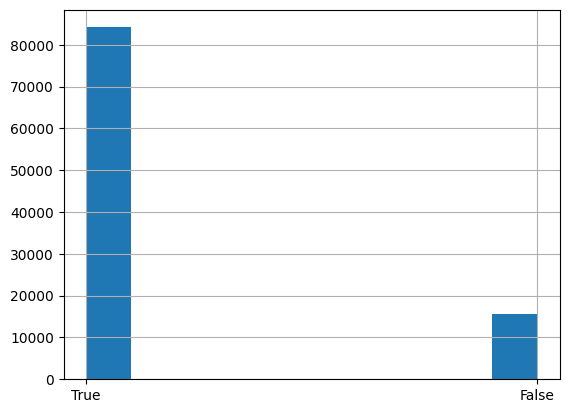

In [23]:
# Гистограмма количества исправленных фраз
(all_patterns_corrected_orthography_and_its_intents_train == all_patterns_and_its_intents_train)["pattern"].apply(lambda x: str(x)).hist()

In [8]:
all_patterns_corrected_orthography_and_its_intents_test = all_patterns_and_its_intents_test.copy()
all_patterns_corrected_orthography_and_its_intents_test["pattern"] = correct_orthography_batch(all_patterns_and_its_intents_test["pattern"], n_batches=100)
all_patterns_corrected_orthography_and_its_intents_test

100%|██████████| 100/100 [01:38<00:00,  1.02it/s]


pattern            intent
0      Уже давно почти никакие, убийства части вторые...     offline_crime
1      Я просто буду протестовать против расизима пол...     offline_crime
2      Как думаете, корейца расстреляют за то, что ег...     offline_crime
3      похож на одного поца, которого мы сейчас в теч...     offline_crime
4         Еще и Сердюков был. Табуреточник и налоговик..     offline_crime
...                                                  ...               ...
24992  Странные у вас отношения!Такие решения самосто...  social_injustice
24993  оставайтесь в государственном пенсионном фонде...  social_injustice
24994  В отпуске по уходу за ребенком я получала NUMB...  social_injustice
24995  При смерти страны всегда только в столице жить...  social_injustice
24996     без образования буш  в день получать до пенсии  social_injustice

[24997 rows x 2 columns]

In [10]:
all_patterns_corrected_orthography_and_its_intents_test["pattern"] = all_patterns_corrected_orthography_and_its_intents_test["pattern"].apply(lambda x: x[:-1])
all_patterns_corrected_orthography_and_its_intents_test

pattern            intent
0      Уже давно почти никакие, убийства части вторые...     offline_crime
1      Я просто буду протестовать против расизима пол...     offline_crime
2      Как думаете, корейца расстреляют за то, что ег...     offline_crime
3      похож на одного поца, которого мы сейчас в теч...     offline_crime
4          Еще и Сердюков был. Табуреточник и налоговик.     offline_crime
...                                                  ...               ...
24992  Странные у вас отношения!Такие решения самосто...  social_injustice
24993  оставайтесь в государственном пенсионном фонде...  social_injustice
24994  В отпуске по уходу за ребенком я получала NUMB...  social_injustice
24995  При смерти страны всегда только в столице жить...  social_injustice
24996      без образования буш  в день получать до пенси  social_injustice

[24997 rows x 2 columns]

In [11]:
all_patterns_corrected_orthography_and_its_intents_test.to_csv(
    path_to_data / 'all_patterns_corrected_orthography_and_its_intents_test.csv', sep=";", encoding='utf-8',
    index=False)

<AxesSubplot: >

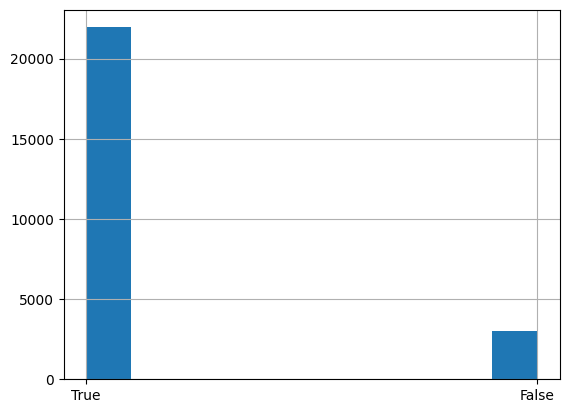

In [24]:
(all_patterns_corrected_orthography_and_its_intents_test == all_patterns_and_its_intents_test)["pattern"].apply(lambda x: str(x)).hist()

In [27]:
preprocess_sentence

Pipeline(steps=[('removegarbage', RemoveGarbage()),
                ('correctorthography', CorrectOrthography(lang=['en', 'ru'])),
                ('removepunctuation', RemovePunctuation()),
                ('tokenize', Tokenize()), ('tobaseform', ToBaseForm()),
                ('removestopwords', RemoveStopWords())])

In [28]:
preprocess_sentence.steps = preprocess_sentence.steps[2:]
preprocess_sentence

Pipeline(steps=[('removepunctuation', RemovePunctuation()),
                ('tokenize', Tokenize()), ('tobaseform', ToBaseForm()),
                ('removestopwords', RemoveStopWords())])

In [29]:
all_patterns_preprocessed_and_its_intents_train = preprocess_patterns(all_patterns_corrected_orthography_and_its_intents_train, preprocess_sentence)
all_patterns_preprocessed_and_its_intents_train

100%|██████████| 99686/99686 [4:37:04<00:00,  6.00it/s]  


pattern            intent
0      [жить, всё, понятие, закон, просто, преступлен...     offline_crime
1      [удовольствие, пообщаться, хардингуш, тип, чёт...     offline_crime
2      [вообще, запретить, судить, сводка, дтп, это, ...     offline_crime
3                        [полковник, миллиард, воровать]     offline_crime
4      [чебоксары, гайец, увидеть, регион, палка, сра...     offline_crime
...                                                  ...               ...
99681           [зарплата, швейцария, чтожий, маленький]  social_injustice
99682  [number-number, час, день, начать, серьёзно, и...  social_injustice
99683  [налог, слишком, мало, нужно, большой, чтогда,...  social_injustice
99684  [чтолько, постройка, соответствовать, строител...  social_injustice
99685  [везде, просчто, жесть, но-в, number, очередь,...  social_injustice

[99686 rows x 2 columns]

In [30]:
all_patterns_preprocessed_and_its_intents_test = preprocess_patterns(all_patterns_corrected_orthography_and_its_intents_test, preprocess_sentence)
all_patterns_preprocessed_and_its_intents_test

100%|██████████| 24997/24997 [1:10:01<00:00,  5.95it/s]


pattern            intent
0      [давно, никакой, убийство, часть, второй, редк...     offline_crime
1      [просто, протестовать, против, расизима, полиц...     offline_crime
2      [думать, кореец, расстрелять, китаец, обойти, ...     offline_crime
3      [похожий, поца, который, течение, месяц, чмыри...     offline_crime
4               [ещё, сердюков, табуреточник, налоговик]     offline_crime
...                                                  ...               ...
24992  [странный, отношениятакий, решение, самостояте...  social_injustice
24993  [оставаться, государственный, пенсионный, фонд...  social_injustice
24994  [отпуск, уход, ребёнок, получать, number, тыся...  social_injustice
24995  [смерть, страна, столица, жить, пропасть, кото...  social_injustice
24996          [образование, буш, день, получать, пенсь]  social_injustice

[24997 rows x 2 columns]

In [31]:
is_pattern_empty = all_patterns_preprocessed_and_its_intents_train['pattern'].apply(lambda x: len(x) == 0)
# из-за удаления стоп-слов могут быть пустые обработанные паттерны
all_patterns_preprocessed_and_its_intents_train[is_pattern_empty]

pattern        intent
14953      []         drugs
18736      []      gambling
19063      []      gambling
21028      []      gambling
21756      []      gambling
22869      []      gambling
23004      []      gambling
27581      []   pornography
34717      []  prostitution
34900      []  prostitution
39347      []       slavery

In [32]:
is_pattern_empty = all_patterns_preprocessed_and_its_intents_test['pattern'].apply(lambda x: len(x) == 0)
# из-за удаления стоп-слов могут быть пустые обработанные паттерны
all_patterns_preprocessed_and_its_intents_test[is_pattern_empty]

pattern    intent
4719      []  gambling
5845      []  gambling

In [33]:
is_pattern_empty = all_patterns_preprocessed_and_its_intents_train['pattern'].apply(lambda x: len(x) == 0)
all_patterns_preprocessed_and_its_intents_train = all_patterns_preprocessed_and_its_intents_train[~is_pattern_empty]
all_patterns_preprocessed_and_its_intents_train

pattern            intent
0      [жить, всё, понятие, закон, просто, преступлен...     offline_crime
1      [удовольствие, пообщаться, хардингуш, тип, чёт...     offline_crime
2      [вообще, запретить, судить, сводка, дтп, это, ...     offline_crime
3                        [полковник, миллиард, воровать]     offline_crime
4      [чебоксары, гайец, увидеть, регион, палка, сра...     offline_crime
...                                                  ...               ...
99681           [зарплата, швейцария, чтожий, маленький]  social_injustice
99682  [number-number, час, день, начать, серьёзно, и...  social_injustice
99683  [налог, слишком, мало, нужно, большой, чтогда,...  social_injustice
99684  [чтолько, постройка, соответствовать, строител...  social_injustice
99685  [везде, просчто, жесть, но-в, number, очередь,...  social_injustice

[99675 rows x 2 columns]

In [34]:
is_pattern_empty = all_patterns_preprocessed_and_its_intents_test['pattern'].apply(lambda x: len(x) == 0)
all_patterns_preprocessed_and_its_intents_test = all_patterns_preprocessed_and_its_intents_test[~is_pattern_empty]
all_patterns_preprocessed_and_its_intents_test

pattern            intent
0      [давно, никакой, убийство, часть, второй, редк...     offline_crime
1      [просто, протестовать, против, расизима, полиц...     offline_crime
2      [думать, кореец, расстрелять, китаец, обойти, ...     offline_crime
3      [похожий, поца, который, течение, месяц, чмыри...     offline_crime
4               [ещё, сердюков, табуреточник, налоговик]     offline_crime
...                                                  ...               ...
24992  [странный, отношениятакий, решение, самостояте...  social_injustice
24993  [оставаться, государственный, пенсионный, фонд...  social_injustice
24994  [отпуск, уход, ребёнок, получать, number, тыся...  social_injustice
24995  [смерть, страна, столица, жить, пропасть, кото...  social_injustice
24996          [образование, буш, день, получать, пенсь]  social_injustice

[24995 rows x 2 columns]

In [35]:
unique_sorted_intents = all_patterns_preprocessed_and_its_intents_train['intent'].unique()
unique_sorted_intents.sort()
unique_sorted_intents

array(['body_shaming', 'drugs', 'gambling', 'health_shaming',
       'offline_crime', 'online_crime', 'politics', 'pornography',
       'prostitution', 'racism', 'religion', 'sexism',
       'sexual_minorities', 'slavery', 'social_injustice', 'suicide',
       'terrorism', 'weapons'], dtype=object)

In [36]:
unique_sorted_words = []
all_patterns_preprocessed_and_its_intents_train['pattern'].map(lambda x: unique_sorted_words.extend(x))
unique_sorted_words_train = np.array(list(set(unique_sorted_words)))
unique_sorted_words.sort()
len(unique_sorted_words)

1005582

In [43]:
all_patterns_preprocessed_and_its_intents_train.to_csv(
    path_to_data / 'all_patterns_preprocessed_and_its_intents_train.csv', sep=";", encoding='utf-8',
    index=False)
all_patterns_preprocessed_and_its_intents_test.to_csv(
    path_to_data / 'all_patterns_preprocessed_and_its_intents_test.csv', sep=";", encoding='utf-8',
    index=False)
np.save(str(path_to_data / "unique_sorted_words.npy"), unique_sorted_words)
np.save(str(path_to_data / "unique_sorted_intents.npy"), unique_sorted_intents)

In [41]:
fix_typos = FixTypos().fit(unique_sorted_words)
fix_typos

FixTypos()

In [42]:
joblib.dump(fix_typos, path_to_models / 'pipelines' / 'fix_typos.joblib')
ModelLoader.load(path_to_models / 'pipelines' / 'fix_typos.joblib').transform("прииивет")

'привет'